In [29]:
# Initialize plotting:
%matplotlib inline
# Import all relevant packages
import PIL
from PIL import Image
import scipy.ndimage
import numpy as np, matplotlib.pyplot as plt
import scipy.stats
import scipy as sp
from ipywidgets import interact
from scipy.integrate import solve_ivp

from importlib import reload
from IPython.display import clear_output, display

# Suppress some logging messages in Pillow (Python Imaging Library)
import logging; logging.getLogger('PIL').setLevel(logging.ERROR)  # Suppress PIL messages


# Fourier Techniques



## The Problems

### Problem 1: Derivatives

Use Fourier techniques to compute derivatives, and to explicitly solve linear minimization problems like the denoising problem.

Specifically, use Fourier techniques to differentiate the following periodic function:

\begin{align*}
  f_{\eta}(x) &= \exp\left(\frac{-1}{1+\eta\cos(k x)}\right),\\
  f'_{\eta}(x) &= \frac{-\eta k \sin(k x)}{\bigl(1+\eta\cos(k x)\bigr)^2}f_{\eta}(x),\\
  f''_{\eta}(x) &= 
  \frac{-\eta k^2\Bigl(\eta\bigl(1 + \cos^2(kx) - \eta\cos^3(kx)\bigr) + (1+2\eta^2)\cos(kx)\Bigr)}{\bigl(1+\eta\cos(k x)\bigr)^4}
  f_{\eta}(x)
\end{align*}

where $k = 2\pi n/L$ is one of the lattice momenta to ensure that the function has appropriate periodicity.



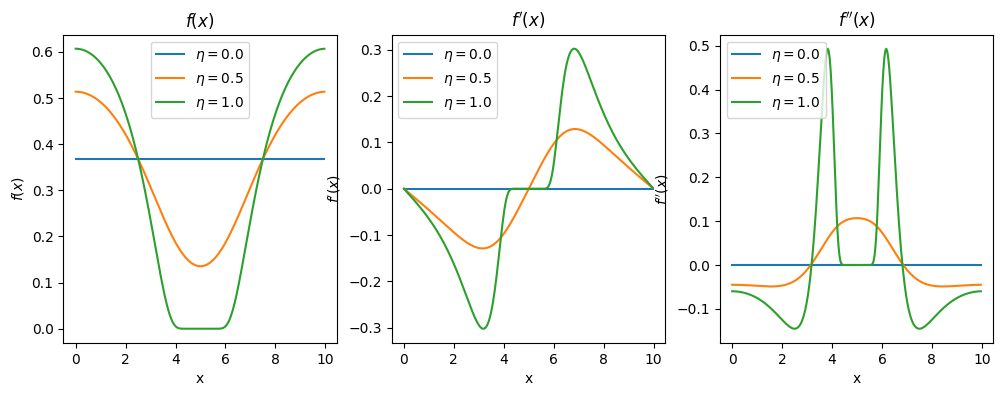

In [31]:
import denoise

_EPS = np.finfo(float).eps  # Small number to prevent divide by zero

L = 10.0

def f(x, eta=1, d=0, n=1, L=L):
    """Return the dth derivative of f(x)."""
    k = 2 * np.pi * n / L
    c = np.cos(k * x)
    eta_c_1 = eta * c + 1 + _EPS
    f = np.exp(-1 / eta_c_1)
    if d == 0:
        res = f
    elif d == 1:
        res = -eta * k / eta_c_1**2 * np.sin(k * x) * f
    elif d == 2:
        c2 = c**2
        c3 = c * c2
        res = -eta * k**2 / eta_c_1**4 * (eta * (1 + c2 - eta * c3) +
                                          (1 + 2 * eta**2) * c) * f
    return res


N = 256
dx = L / N
x = np.arange(N) * dx

fig, axs = denoise.subplots(3, height=4)
for n, eta in enumerate([0, 0.5, 1.0]):
    c = f"C{n}"
    label = rf"$\eta={eta:.1f}$"
    axs[0].plot(x, f(x, eta=eta), c=c, label=label)
    axs[1].plot(x, f(x, d=1, eta=eta), c=c, label=label)
    axs[2].plot(x, f(x, d=2, eta=eta), c=c, label=label)
for ax, title in zip(axs, ["$f(x)$", "$f'(x)$", "$f''(x)$"]):
    ax.legend()
    ax.set(title=title, xlabel="x", ylabel=title)

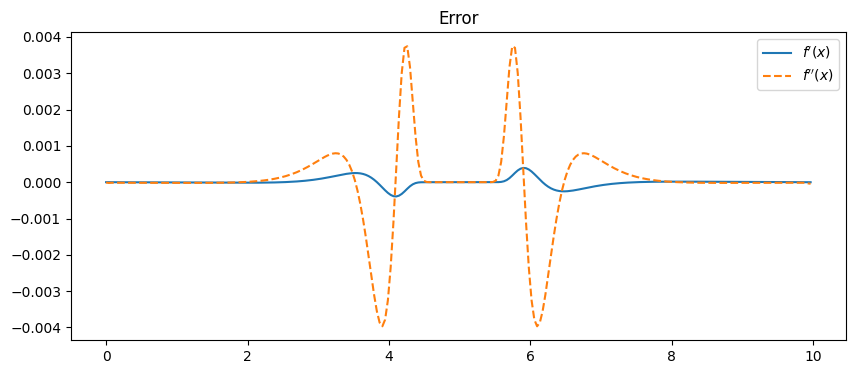

In [32]:
# Compute the derivatives. Explore their convergence.
N = 256
dx = L / N
x = np.arange(N) * dx
f_x = f(x)

df_x = np.gradient(f_x, x, edge_order=2)
ddf_x = np.gradient(df_x, x, edge_order=2)

fig, ax = denoise.subplots(figsize=(10,4))
ax.plot(x, df_x - f(x, d=1), '-C0', label="$f'(x)$")
ax.plot(x, ddf_x - f(x, d=2), '--C1', label="$f''(x)$")
ax.legend()
ax.set(title="Error");

### Problem 2: Denoising

Solve the equation

\begin{gather}
  E'[u] = -\nabla^2 u + \lambda (u - d) = 0
 \end{gather}

where $u$ and $d$ are images.

In [33]:
sigma = 0.4
lam = 1.0
im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam, mode="periodic")
u_exact = im.get_data(sigma=0)
u_noise = im.get_data(sigma=sigma)
u = d.minimize()
E_u = d.get_energy(u)
E_noise = d.get_energy(u_noise)
E_exact = d.get_energy(u_exact)

E=0.2116, E_r=0.2107, E_f=0.000924
E=0.04438, E_r=0.01946, E_f=0.02492
E=0.0396, E_r=0.01214, E_f=0.02746
E=0.03761, E_r=0.007515, E_f=0.0301
E=0.0372, E_r=0.006876, E_f=0.03032
E=0.03705, E_r=0.006769, E_f=0.03028
E=0.037, E_r=0.006642, E_f=0.03035
E=0.03698, E_r=0.006511, E_f=0.03046
E=0.03697, E_r=0.006454, E_f=0.03051
E=0.03697, E_r=0.006462, E_f=0.0305
E=0.03696, E_r=0.00647, E_f=0.03049
E=0.03696, E_r=0.006467, E_f=0.0305
E=0.03696, E_r=0.006462, E_f=0.0305
E=0.03696, E_r=0.006462, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305
E=0.03696, E_r=0.006461, E_f=0.0305


KeyboardInterrupt: 

In [34]:
# Implement solve
u_solve = d.solve()

In [35]:
fig, axs = denoise.subplots(5)
for _u, title, ax in [(u_exact, rf"Original: $\sigma=0$, $E={E_exact:.2g}$", axs[0]),
                     (u_noise, rf"Data: $\sigma={sigma}$, $E={E_noise:.2g}$", axs[1]),
                     (u, rf"Minimizer: $E={E_u:.2g}$", axs[2]),
                     (u_solve, "Your solver", axs[3]),
                     (u-u_solve, f"Max diff: {abs(u-u_solve).max():.4g}", axs[4])
                     ]:
    im.show(_u, ax=ax)
    ax.set(title=title);

## Exploration

### Derivatives

We start with finite differences using the following formulae:

\begin{align*}
  f'(x) &= \frac{f(x+h) - f(x)}{h} + \frac{h}{2}f''(x^*),\\
  f'(x) &= \frac{f(x+h)-f(x-h)}{2h} + \frac{h^2}{6}f'''(x^*),\\
  f''(x) &= \frac{f(x+h) -2f(x) + f(x)}{h^2} + \frac{h^2}{12}f''''(x^*).
\end{align*}

where $x^*$ is some point between $x-h$ and $x+h$.  These can be derived from the Taylor expansions.
$$
  f(x\pm h) = f(x) \pm h f'(x) + \frac{h^2}{2}f''(x) \pm \frac{h^3}{3!}f'''(x) + \cdots.
$$



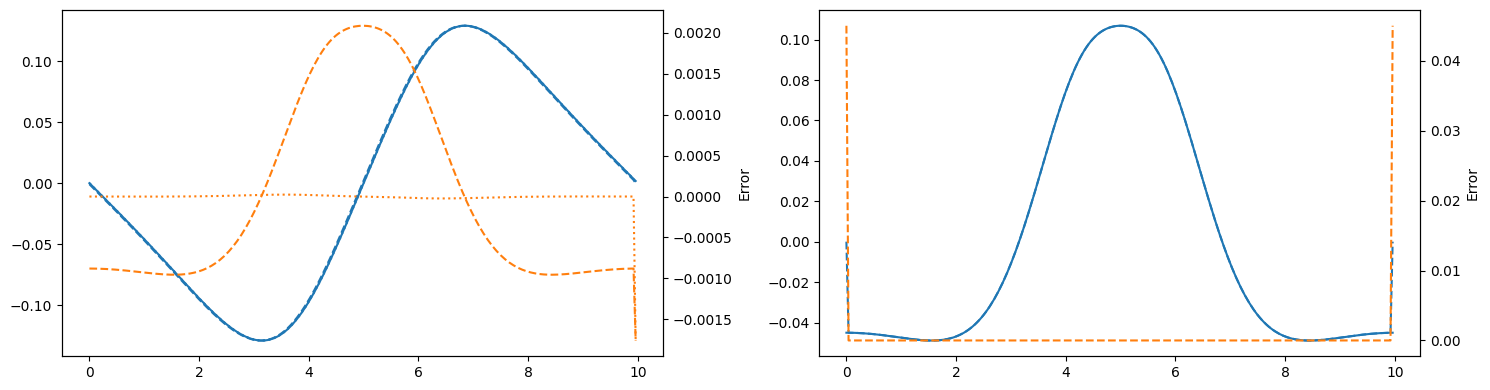

In [36]:
import denoise

_EPS = np.finfo(float).eps  # Small number to prevent divide by zero

L = 10.0


def f(x, eta=1, d=0, n=1, L=L):
    """Return the dth derivative of f(x)."""
    k = 2 * np.pi * n / L
    c = np.cos(k * x)
    eta_c_1 = eta * c + 1 + _EPS
    f = np.exp(-1 / eta_c_1)
    if d == 0:
        res = f
    elif d == 1:
        res = -eta * k / eta_c_1**2 * np.sin(k * x) * f
    elif d == 2:
        c2 = c**2
        c3 = c * c2
        res = -eta * k**2 / eta_c_1**4 * (eta * (1 + c2 - eta * c3) +
                                          (1 + 2 * eta**2) * c) * f
    return res


def D1_r(f, x):
    """Compute the derivative of f using right-sided finite differences."""
    df = np.zeros_like(f)
    df[:-1] = (f[1:] - f[:-1]) / np.diff(x)

    # Can you do better for the right boundary?
    df[-1] = 0
    return df


def D1_c(f, x):
    """Compute the derivative of f using centered finite differences."""
    df = np.zeros_like(f)
    df[1:-1] = (f[2:] - f[:-2]) / (x[2:] - x[:-2])

    # Can you do better for the boundaries?
    df[0] = 0
    df[-1] = 0
    return df

def D2_c(f, x):
    """Compute the second derivative of f using centered finite differences."""
    d2f = np.zeros_like(f)
    d2f[1:-1] = (f[2:] - 2*f[1:-1] + f[:-2]) / (x[2:] - x[1:-1]) / (x[1:-1] - x[:-2])

    # Can you do better for the boundaries?
    d2f[0] = 0
    d2f[-1] = 0
    return d2f
N = 256
dx = L / N
x = np.arange(N) * dx
Eta = 0.5
f_x = f(x, eta = Eta)

fig, axs = denoise.subplots(2, figsize=(15, 4))
ax = axs[0]
ax.plot(x, f(x,eta = Eta, d=1), "-C0")
ax.plot(x, D1_r(f_x, x), "--C0")
ax.plot(x, D1_c(f_x, x), ":C0")
ax_ = ax.twinx()
ax_.plot(x, D1_r(f_x, x) - f(x, eta = Eta, d=1), "--C1")
ax_.plot(x, D1_c(f_x, x) - f(x,eta = Eta, d=1), ":C1")
ax_.set(ylabel="Error")

ax = axs[1]
ax.plot(x, f(x,eta = Eta, d=2), "-C0")
ax.plot(x, D2_c(f_x, x), "--C0")
ax_ = ax.twinx()
ax_.plot(x, D2_c(f_x, x) - f(x,eta = Eta, d=2), "--C1")
ax_.set(ylabel="Error"); fig.tight_layout()


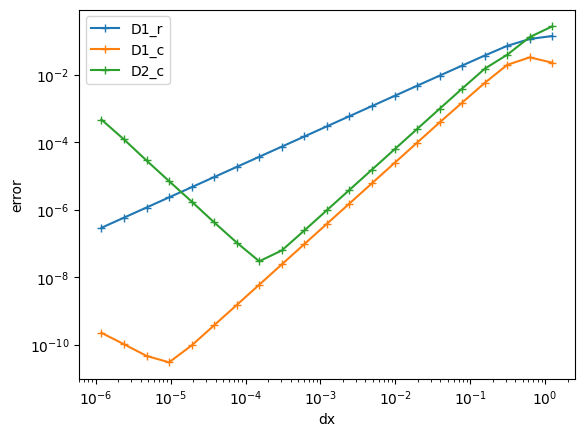

In [37]:
Ns = 2**np.arange(3, 24)
dxs = L/Ns
errs = []
for dx, N in zip(dxs, Ns):
    x = np.arange(N) * dx
    f_x = f(x)
    # Ignore errors at the ends for now
    err1_r = abs(D1_r(f_x, x) - f(x, d=1))[1:-1].max()
    err1_c = abs(D1_c(f_x, x) - f(x, d=1))[1:-1].max()
    err2_c = abs(D2_c(f_x, x) - f(x, d=2))[1:-1].max()
    errs.append((err1_r, err1_c, err2_c))
errs = np.asarray(errs)
fig, ax = plt.subplots()

for err, label in zip(errs.T, ["D1_r", "D1_c", "D2_c"]):
    ax.loglog(dxs, err, '-+', label=label)
ax.set(xlabel="dx", ylabel="error")
ax.legend()

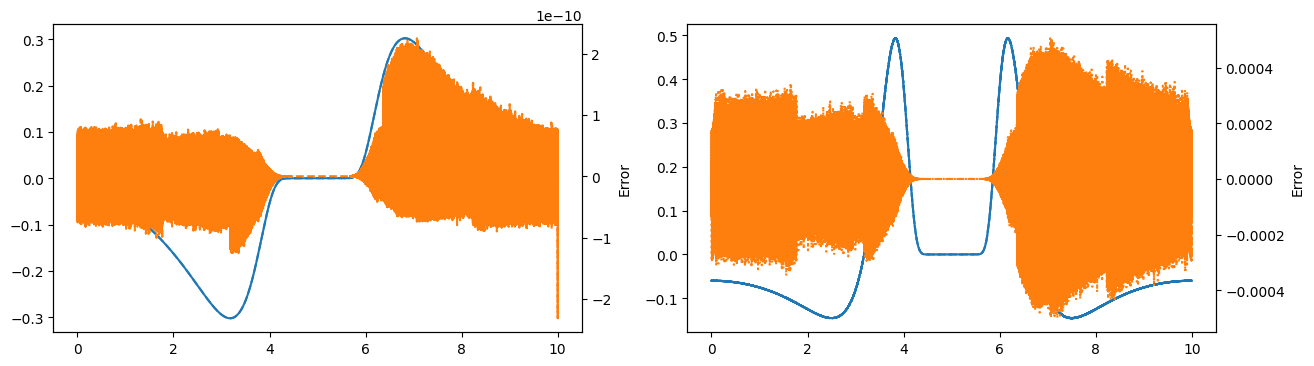

In [38]:
N - 256; dx = L/N; x = np.arange(N)*dx
d1_np = np.gradient(f(x), x, edge_order=2)
d2_np = np.gradient(d1_np, x, edge_order=2)

dx = np.diff(x).mean()
d2_sp = sp.ndimage.laplace(f(x), mode="wrap") / dx**2

fig, axs = denoise.subplots(2, figsize=(15, 4))
ax = axs[0]
ax.plot(x, f(x, d=1), "-C0")
ax.plot(x, d1_np, "--C0", label="NumPy")
ax_ = ax.twinx()
ax_.plot(x, d1_np - f(x, d=1), "--C1")
ax_.set(ylabel="Error")

ax = axs[1]
ax.plot(x, f(x, d=2), "-C0")
ax.plot(x, d2_np, "--C0", label="NumPy")
ax.plot(x, d2_sp, ":C0", label="SciPy")
ax_ = ax.twinx()
ax_.plot(x, d2_np - f(x, d=2), "--C1")
ax_.plot(x, d2_sp - f(x, d=2), ":C1")
ax_.set(ylabel="Error");

#### Fourier Techniques

Use Fourier techniques.

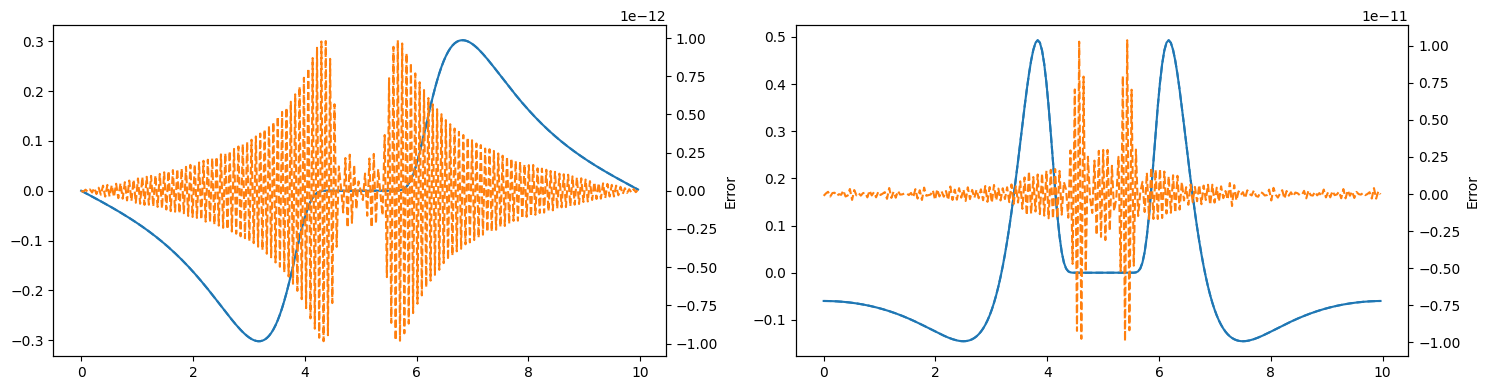

In [28]:
Eta = 1

def D1_f(f, x):
    """Compute the derivative of f using Fourier methods."""
    dx = np.diff(x).mean()
    N = len(f)
    kx = 2*np.pi * np.fft.fftfreq(N, dx)
    df = np.fft.ifft(1j*kx * np.fft.fft(f))
    #assert np.allclose(df.imag, 0)
    return df.real

def D2_f(f, x):
    """Compute the second derivative of f using Fourier methods."""
    dx = np.diff(x).mean()
    N = len(f)
    kx = 2*np.pi * np.fft.fftfreq(N, dx)
    df = np.fft.ifft(-kx**2 * np.fft.fft(f))
    #assert np.allclose(df.imag, 0)
    return df.real

N = 256
dx = L / N
x = np.arange(N) * dx
f_x = f(x, eta = Eta)

# interact(eta=(0.0,20.0,0.5))
# Eta = np.linspace(0,1)
# ipywidgets.interact(f(x,eta=Eta),Eta)

fig, axs = denoise.subplots(2, figsize=(15, 4))
ax = axs[0]
ax.plot(x, f(x, eta = Eta, d=1), "-C0")
ax.plot(x, D1_f(f_x, x), "--C0")
ax_ = ax.twinx()
ax_.plot(x, D1_f(f_x, x) - f(x, eta = Eta, d=1), "--C1")
ax_.set(ylabel="Error")

ax = axs[1]
ax.plot(x, f(x,eta = Eta, d=2), "-C0")
ax.plot(x, D2_f(f_x, x), "--C0")
ax_ = ax.twinx()
ax_.plot(x, D2_f(f_x, x) - f(x, eta = Eta, d=2), "--C1")
ax_.set(ylabel="Error"); fig.tight_layout()

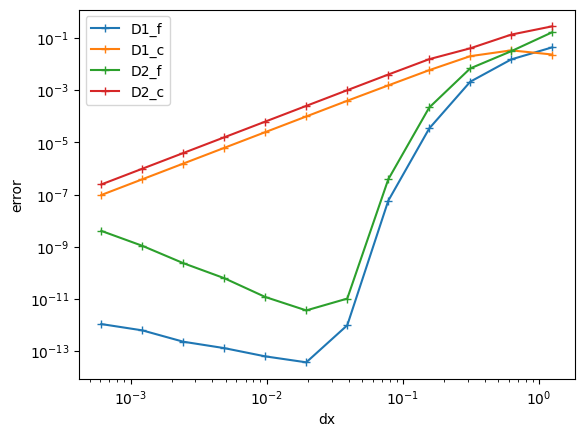

In [39]:
Ns = 2**np.arange(3, 15)
dxs = L/Ns
errs = []
Eta = 1
for dx, N in zip(dxs, Ns):
    x = np.arange(N) * dx
    f_x = f(x, eta = Eta)
    # Ignore errors at the ends for now
    err1 = abs(D1_f(f_x, x) - f(x, eta = Eta, d=1))[1:-1].max()
    err1_c = abs(D1_c(f_x, x) - f(x, eta = Eta, d=1))[1:-1].max()
    err2 = abs(D2_f(f_x, x) - f(x, eta = Eta, d=2))[1:-1].max()
    err2_c = abs(D2_c(f_x, x) - f(x, eta = Eta, d=2))[1:-1].max()
    errs.append((err1, err1_c, err2, err2_c))
errs = np.asarray(errs)
fig, ax = plt.subplots()

for err, label in zip(errs.T, ["D1_f", "D1_c", "D2_f", "D2_c"]):
    ax.loglog(dxs, err, '-+', label=label)
ax.set(xlabel="dx", ylabel="error")
ax.legend()


#### Derivative Matrices

The derivative is a linear operator, so we should be able to represent it as a matrix.  Here we are explicit about this.

In [40]:
import fourier_techniques
reload(fourier_techniques)
from fourier_techniques import f, L
import denoise

N = 256
dx = L/N
x = np.arange(N) * dx


Dr = (np.diag(np.ones(N-1), k=1) - np.diag(np.ones(N))) / dx
Dl = (np.diag(np.ones(N)) - np.diag(np.ones(N-1), k=-1)) / dx
Dc = (np.diag(np.ones(N-1), k=1) - np.diag(np.ones(N-1), k=-1)) / 2 / dx
D2 = Dl @ Dr
assert np.allclose(Dr, -Dl.T)
assert np.allclose(Dc, -Dc.T)
assert np.allclose(Dc, (Dr + Dl)/2)
assert np.allclose(D2, D2.T)

print("Dr")
print(Dr * dx)

print("Dl")
print(Dl * dx)

print("Dc")
print(Dc * dx)

print("D2")
print(D2 * dx**2)

Dr
[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0. -1.]]
Dl
[[ 1.  0.  0. ...  0.  0.  0.]
 [-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]
Dc
[[ 0.   0.5  0.  ...  0.   0.   0. ]
 [-0.5  0.   0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]
 [ 0.   0.   0.  ...  0.  -0.5  0. ]]
D2
[[-1.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]


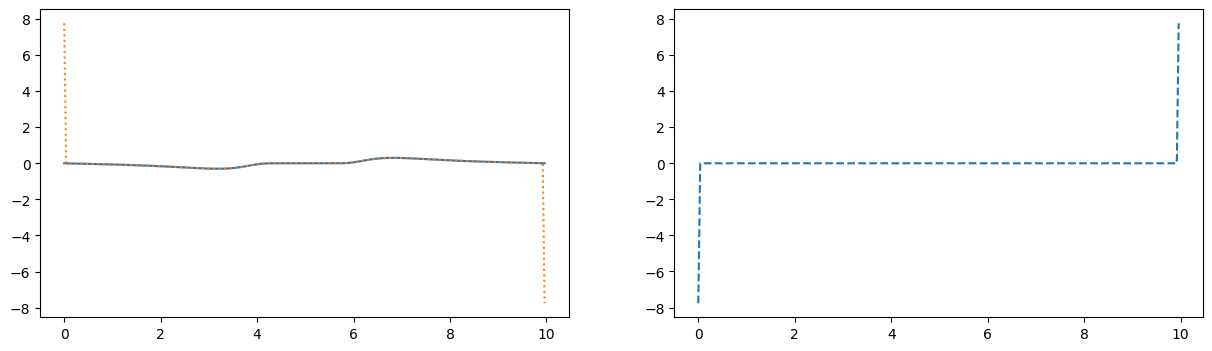

In [41]:
f_x = f(x, L=L)
df_x = f(x, L=L, d=1)
ddf_x = f(x, L=L, d=2)

fig, axs = denoise.subplots(2, figsize=(15,4))
axs[0].plot(x, df_x, '-', x, Dc @ f_x, ':')
axs[1].plot(x, df_x - Dc @ f_x, '--')

If you want to get the matrix corresponding to a more complicated routine, you can simply apply it to the basis vectors:

In [42]:
I = np.eye(N)

for mode in ["reflect", "wrap", "constant"]:
    D_sp = np.array([sp.ndimage.laplace(I[:, _n], mode=mode) for _n in range(N)]) / dx
    print(f"{mode=}")
    print(D_sp * dx)

D1f = np.array([fourier_techniques.D1_f(I[:, _n], x) for _n in range(N)])
D2f = np.array([fourier_techniques.D2_f(I[:, _n], x) for _n in range(N)])
print("Fourier 1")
print(D1f * dx)

print("Fourier 2")
print(D2f * dx**2)

# Check
x = np.arange(N) * dx
kx = 2*np.pi * np.fft.fftfreq(N, dx)

F = np.exp(-1j*kx[:, np.newaxis]*x[np.newaxis, :])
Finv = np.exp(1j*x[:, np.newaxis]*kx[np.newaxis, :])/N

assert np.allclose(F.T.conj(), Finv * N)
assert np.allclose(Finv @ F, I)
assert np.allclose(F @ f(x), np.fft.fft(f(x)))
assert np.allclose(Finv @ f(x), np.fft.ifft(f(x)))

assert np.allclose(Finv @ np.diag(-kx**2) @ F, D2f)
assert np.allclose((Finv @ np.diag(-1j*kx) @ F).real, D1f)  # Why is real needed here?

mode='reflect'
[[-1.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -1.]]
mode='wrap'
[[-2.  1.  0. ...  0.  0.  1.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 1.  0.  0. ...  0.  1. -2.]]
mode='constant'
[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]
Fourier 1
[[ 0.00000000e+00 -9.99949800e-01  4.99899597e-01 ...  3.33182722e-01
  -4.99899597e-01  9.99949800e-01]
 [ 9.99949800e-01 -4.06575815e-19 -9.99949800e-01 ... -2.49799170e-01
   3.33182722e-01 -4.99899597e-01]
 [-4.99899597e-01  9.99949800e-01 -6.99013940e-18 ...  1.99748940e-01
  -2.49799170e-01  3.33182722e-01]
 ...
 [-3.33182722e-01  2.49799170e-01 -1.99748940e-01 .

### Images

Text(0.5, 1.0, 'Error')

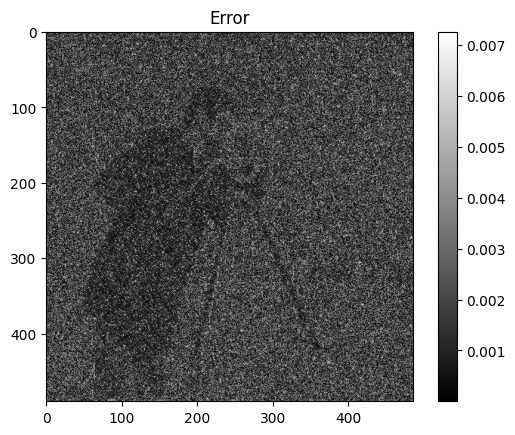

In [43]:
import denoise

sigma = 0.4
lam = 0.1

im = denoise.Image()
d = denoise.Denoise(image=im, sigma=sigma, lam=lam, mode="wrap")

Nx, Ny = im.shape
dx = dy = 1.0
x = (np.arange(Nx) * dx)[:, None]
y = (np.arange(Ny) * dy)[None, :]
kx = 2 * np.pi * np.fft.fftfreq(Nx, dx)[:, None]
ky = 2 * np.pi * np.fft.fftfreq(Ny, dy)[None, :]

fft, ifft = np.fft.fftn, np.fft.ifftn

u = ifft(lam * fft(d.u_noise) / (lam + (kx**2 + ky**2)))

# Why does this work?
# u = ifft(lam * fft(d.u_noise) / (lam + 2*(2-np.cos(kx)-np.cos(ky))))

assert np.allclose(u.imag, 0)
u_fft = u.real

u_solve = d.minimize()
# u_solve = d.solve()  # Cheating... sort of

clear_output()
data = [
    ("Original", d.u_exact),
    ("Noise", d.u_noise),
    ("FFT", u_fft),
    ("Minimize", u_solve),
]
fig, axs = denoise.subplots(len(data))
for ax, (title, u) in zip(axs, data):
    im.show(u, ax=ax)
    ax.set(title=title)

plt.figure()
plt.imshow(abs(u_solve - u_fft));
plt.colorbar()
plt.title("Error")